In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
os.chdir('/content/drive/My Drive/kds/1sem/ditw/ditw_project')
os.listdir()

['.gitignore',
 'academic_creds.json',
 'credentials.json',
 'pyproject.toml',
 'poetry.lock',
 'README.md',
 '.venv',
 '.git',
 'data',
 '.ipynb_checkpoints',
 'src']

In [5]:
!pip install sentence_transformers
!pip install hdbscan
!pip install umap-learn
!pip install matplotlib
!pip install pandas

In [6]:
from src.json_utils import read_json, read_jsonl
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt
import pandas as pd
from src.preprocessing import *

In [7]:
data = read_jsonl('data/dkpol_tweets.jsonl')
df = pd.DataFrame(data)
df = df[df['in_reply_to_user_id'].isna()]
#subset = df.sample(200, random_state = 42)

Reading data/dkpol_tweets.jsonl


In [8]:
import matplotlib.pyplot as plt
from collections import Counter

entities = list(df['entities'].values)
hashtags = list()
for e in entities:
    try:
        for tag in e['hashtags']:
            hashtags.append(tag['tag'])
    except:
        continue

Counter(hashtags).most_common(10)

[('dkpol', 56598),
 ('dkmedier', 8069),
 ('dkgreen', 4159),
 ('dkbiz', 2072),
 ('sundpol', 1718),
 ('uddpol', 1067),
 ('arbejde', 1060),
 ('dkøko', 1020),
 ('eudk', 993),
 ('svpol', 856)]

In [9]:
# for i in subset.head(20).iterrows():
#     print(i[1]['text'])
#     if 'urls' in i[1]['entities']:
#         print(i[1]['entities']['hashtags'])
#     print()

In [10]:
text = replace_url(df['text'])
# for i in text[:50]:
#     print(i)
#     print()

In [11]:
encoder = SentenceTransformer('Maltehb/-l-ctra-danish-electra-small-cased')
embeddings = encoder.encode(text, show_progress_bar=True, normalize_embeddings=True)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/Maltehb_-l-ctra-danish-electra-small-cased were not used when initializing ElectraModel: ['generator.embeddings.LayerNorm.bias', 'generator.encoder.layer.9.attention.output.dense.bias', 'generator.encoder.layer.10.attention.output.LayerNorm.bias', 'generator.encoder.layer.4.attention.output.dense.bias', 'generator.encoder.layer.2.attention.output.LayerNorm.bias', 'generator.encoder.layer.3.attention.self.value.bias', 'generator.encoder.layer.10.attention.output.LayerNorm.weight', 'generator.encoder.layer.11.intermediate.dense.weight', 'generator.encoder.layer.11.attention.self.key.weight', 'generator.encoder.layer.8.attention.self.key.weight', 'generator.encoder.layer.8.output.LayerNorm.bias', 'generator.encoder.layer.1.attention.output.LayerNorm.bias', 'generator.encoder.layer.1.output.LayerNorm.weight', 'generator.encoder.layer.7.attention.self.query.weight', 'generator.encoder.layer.7.attention.output.d

Batches:   0%|          | 0/1803 [00:00<?, ?it/s]

In [12]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [20]:
cluster = hdbscan.HDBSCAN(min_cluster_size=30,
                          metric='euclidean',                      
                          cluster_selection_method='eom', seed = 42).fit(umap_embeddings)

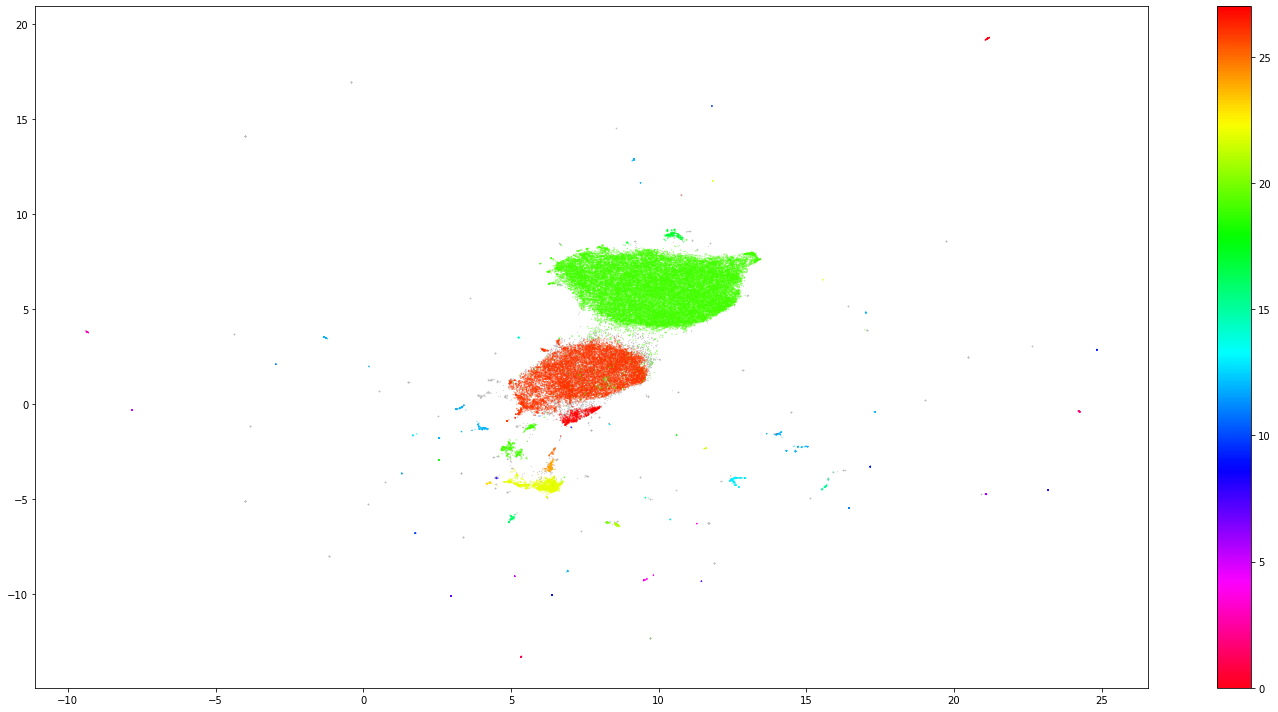

In [21]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.tight_layout()

In [22]:
docs_df = pd.DataFrame(text, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [23]:
with open('data/danish_stopwords.txt') as stop_file:
  stopwords = [word.strip() for word in stop_file.readlines()]
stopwords[:5]

['ad', 'af', 'aldrig', 'alene', 'alle']

In [24]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 3)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=frozenset(stopwords)).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bl', 'ca', 'eks', 'pga'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [25]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(20)

,Topic,Size
20,19,34392
27,26,12533
0,-1,4957
23,22,1728
28,27,777
13,12,625
1,0,350
18,17,292
14,13,287
22,21,228


In [38]:
top_n_words[3][:10]

[('dkpol url dkpol', 0.6827454206212675),
 ('url dkpol url', 0.6093897524834175),
 ('url dkpol', 0.3757121634026452),
 ('dkpol url', 0.1969485601588445),
 ('url', 0.04050350040434239),
 ('dkpol', 0.032341758159954256),
 ('gang ringer', 0.0),
 ('gang ringer glædeligt', 0.0),
 ('gang retssag bring', 0.0),
 ('gang retssag korruption', 0.0)]

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(8):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bl', 'ca', 'eks', 'pga'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bl', 'ca', 'eks', 'pga'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bl', 'ca', 'eks', 'pga'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. T

In [40]:
# Get topic ids of alle clusters with more than 200 documents
topic_subset = topic_sizes[topic_sizes.Doc > 200]
topic_subset = list(topic_subset.Topic.values)

In [3]:
cluster_embeddings = {cluster_id: {} for cluster_id in set(cluster.labels_)}
for idx, clu in enumerate(cluster.labels_):
  if clu == -1:
    continue
  cluster_embeddings[clu][idx]=embeddings[idx, :].tolist()

NameError: ignored

In [42]:
avg_embeddings = {}
for idx, embs in cluster_embeddings.items():
  #avg_embeddings[idx] = np.mean(np.array(embs), axis = 0)
  v = np.mean(np.array([val for val in embs.values()]), axis = 0)
  normalized_v = v / np.sqrt(np.sum(v**2))
  avg_embeddings[idx] = normalized_v

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [2]:
topic_subset

NameError: ignored

In [1]:
from sentence_transformers.util import semantic_search
import torch

for cluster_id in topic_subset:
  avg_emb = torch.tensor(avg_embeddings[cluster_id])
  documents = torch.tensor(np.array([val for val in cluster_embeddings[cluster_id].values()]))
  print(documents.size())
  exit()
  top_similar = semantic_search(avg_emb, documents, top_k = 5)
  print(top_similar)

NameError: ignored